# Python для DataScience
## Курсовая работа

В этой курсовой работе мы будем обучать модель, предсказывающую цены на квартиры

In [231]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных

Скачаем датасеты:

In [232]:
from urllib import request
from os.path import isfile

train_url = 'https://uploads.hb.cldmail.ru/asset/1381522/attachment/302b3d11658ce764f4e8655292566e11.csv'
test_url = 'https://uploads.hb.cldmail.ru/asset/1381521/attachment/f74867a92dc85932950369d8d31db3b0.csv'

train_path = 'train.csv'
test_path = 'test.csv'

if not isfile(train_path):
    request.urlretrieve(train_url, train_path)
if not isfile(test_path):
    request.urlretrieve(test_url, test_path)

In [233]:
data = pd.read_csv(train_path)


### Очистка данных
Давайте проанализируем датасет

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [235]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Мы видим ряд результатов, давайте определим ряд заявлений:

#### 25% данных о размерах кухни составляют 1, что не похоже на правду. 
Если это так, то данным признаком следует пренебречь, так как он крайне неточен

Для начала, построим гистограмму распределения квартир по площадям кухни

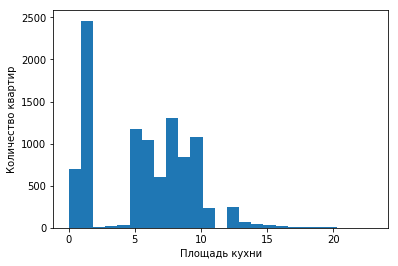

In [236]:
plt.hist(
    data['KitchenSquare'].loc[data.KitchenSquare < 25], 
    bins=25
)

plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show();

Давайте вычислим среднюю площадь квартиры, имеющую кухню площадью 1, а также общий процент таких квартир среди всей выборки

In [237]:
square_with_tiny_kitchen = data.loc[data.KitchenSquare <= 1]['Square'].loc[data.Square < 100]

In [238]:
square_with_tiny_kitchen.mean(), square_with_tiny_kitchen.count() / data['Square'].count()

(57.808910788199775, 0.3045)

Выходит, что 30% квартир имеют площадь кухни 1 и менее, при том что средняя площать среди них 57. Можно было бы объяснить отсутсвие кухонь в случае если объект является общежитием или апартаментами, но не с такой средней площадью. Из этого можно заключить что признак `KitchenSquare` невалиден и должен быть исключен из выборки.

#### 48% записей не имеют значения в признаке  `Healthcare_1`. 
Если этот признак не кореллирует с другими параметрами то его можно исключить из выборки.

Давайте возьмем все непустые значения и оценим

In [239]:
health_param_1 = data[data.Healthcare_1.notnull()]

In [240]:
health_param_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 1 to 9999
Data columns (total 20 columns):
Id               5202 non-null int64
DistrictId       5202 non-null int64
Rooms            5202 non-null float64
Square           5202 non-null float64
LifeSquare       4457 non-null float64
KitchenSquare    5202 non-null float64
Floor            5202 non-null int64
HouseFloor       5202 non-null float64
HouseYear        5202 non-null int64
Ecology_1        5202 non-null float64
Ecology_2        5202 non-null object
Ecology_3        5202 non-null object
Social_1         5202 non-null int64
Social_2         5202 non-null int64
Social_3         5202 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      5202 non-null int64
Shops_1          5202 non-null int64
Shops_2          5202 non-null object
Price            5202 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 853.5+ KB


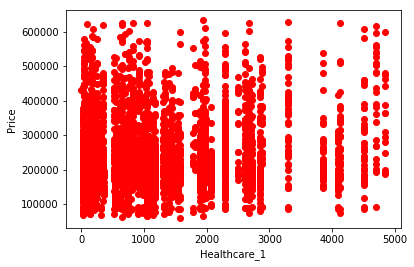

In [241]:
plt.plot(
    health_param_1['Healthcare_1'],
    health_param_1['Price'],
    'ro'
)
plt.xlabel('Healthcare_1')
plt.ylabel('Price')
plt.show();

In [242]:
health_param_1[['Healthcare_1', 'Helthcare_2', 'Price']].corr()

,Healthcare_1,Helthcare_2,Price
Healthcare_1,1.000000,0.203177,0.138755
Helthcare_2,0.203177,1.000000,0.135872
Price,0.138755,0.135872,1.000000


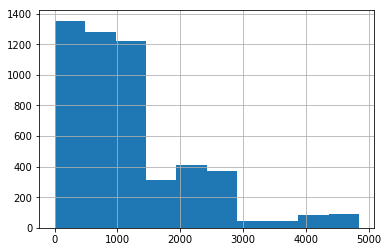

In [243]:
health_param_1['Healthcare_1'].hist();

In [244]:
health_param_1.corr()['Healthcare_1']

Id              -0.003879
DistrictId       0.304335
Rooms            0.042857
Square          -0.039748
LifeSquare      -0.026867
KitchenSquare    0.009472
Floor           -0.138294
HouseFloor      -0.143973
HouseYear       -0.011969
Ecology_1       -0.043547
Social_1         0.077133
Social_2         0.050458
Social_3         0.133877
Healthcare_1     1.000000
Helthcare_2      0.203177
Shops_1          0.057758
Price            0.138755
Name: Healthcare_1, dtype: float64

Выходит, что признак 'Healthcare_1' не кореллирует с остальными, и поскольку заполнен лишь на 50% то он также невалиден и им можно принебречь

#### Оценим признак `Rooms`

In [245]:
data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [246]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Посмотрим на выбросы, когда количество комнат >5:

In [247]:
data[data.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863


Разберемся с записями в 10 комнат

In [248]:
data[data.HouseFloor == 22][data.HouseYear == 2002][data.Square <  60][data.Square > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
5235,1694,29,2.0,59.031566,36.372927,10.0,20,22.0,2002,0.069660,B,B,31,6119,4,NaN,1,2,B,286692.034950


Похожая квартира имеет 2 комнаты, так что поменяем значение

In [249]:
data.loc[data.Id == 5927, 'Rooms'] = 2

Теперь разберемся с квартирой в 10 комнат

In [250]:
data[data.HouseYear == 1994][data.Square <  65][data.Square > 55]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
81,6832,96,2.0,62.783809,35.222368,10.0,5,10.0,1994,0.041116,B,B,53,14892,4,NaN,1,4,B,259293.022122
2318,7973,9,2.0,55.147050,32.213358,9.0,8,17.0,1994,0.069753,B,B,53,13670,4,NaN,1,11,B,242848.699939
3492,5562,153,2.0,57.010780,33.473692,9.0,4,12.0,1994,0.033494,B,B,66,10573,1,1322.0,3,8,B,228489.712265
3523,15426,25,2.0,57.442390,35.046412,9.0,14,14.0,1994,0.069753,B,B,53,13670,4,NaN,1,11,B,229200.700541
4022,10499,41,2.0,55.658606,32.092702,10.0,15,16.0,1994,0.175055,B,B,36,10055,3,NaN,1,0,B,267184.626479
6986,12336,11,2.0,56.460882,28.749149,11.0,5,16.0,1994,0.000170,B,B,36,5992,0,NaN,1,1,B,251233.303824
7377,12491,9,2.0,56.985954,35.588551,10.0,13,14.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,218448.568126
7615,837,9,2.0,57.861546,34.455230,9.0,9,17.0,1994,0.069753,B,B,53,13670,4,NaN,1,11,B,245887.589856
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
9758,7745,59,2.0,62.068711,35.040094,10.0,7,22.0,1994,0.019509,B,B,37,7687,11,176.0,5,5,B,404855.263214


В том же районе похожая по характеристикам квартира имеет 2 комнаты и расположена в 14 этажном доме. 

In [251]:
data.loc[data.Id ==  14865, 'Rooms'] = 2
data.loc[data.Id ==  14865, 'HouseFloor'] = 14

Разберемся с еще одной квартирой в 10 комнат

In [252]:
data[data.HouseFloor == 17][data.HouseYear == 2014]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993
221,4228,7,2.0,67.871545,35.335792,12.0,13,17.0,2014,0.035145,B,B,42,9292,3,2620.0,0,3,B,89269.188169
740,7988,30,1.0,39.918325,NaN,1.0,2,17.0,2014,0.000078,B,B,22,6398,141,1046.0,3,23,B,109274.645286
774,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945
999,10347,74,2.0,66.546999,65.220617,1.0,17,17.0,2014,0.309479,B,B,35,7715,4,990.0,0,6,B,156028.369596
1094,7350,6,1.0,41.775449,21.529262,7.0,11,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,118142.776769
1187,4281,6,2.0,64.598325,61.316162,1.0,15,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,183591.206261
1407,401,23,1.0,43.358552,20.654766,8.0,2,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,98079.424214
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1734,13537,6,1.0,38.874335,41.379287,1.0,5,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,128043.355789


In [253]:
data.loc[data.Id == 8491, 'Rooms'] = 1

Разберемся с квартирой на 6 комнат

In [254]:
data[data.DistrictId == 99][data.Square < 65][data.Square > 55][data.HouseFloor == 9]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1510,13793,99,3.0,61.212908,41.640690,6.0,1,9.0,1973,0.012339,B,B,35,5776,1,2078.0,2,4,B,223960.229617
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
2602,1594,99,3.0,57.619269,40.282178,6.0,5,9.0,1955,0.033494,B,B,66,10573,1,1322.0,3,8,B,239739.535546
4052,9808,99,3.0,61.990876,46.009688,5.0,5,9.0,1970,0.033494,B,B,66,10573,1,1322.0,3,8,B,197293.229058
4056,9618,99,3.0,60.700694,45.087221,6.0,2,9.0,1970,0.012339,B,B,35,5776,1,2078.0,2,4,B,211387.173697
6174,2022,99,3.0,62.683364,45.367528,6.0,1,9.0,1973,0.012339,B,B,35,5776,1,2078.0,2,4,B,93834.252928
6810,10794,99,3.0,62.841601,48.645919,6.0,5,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,226202.834701
7504,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
8235,2104,99,3.0,64.975067,45.550797,6.0,3,9.0,1971,0.012339,B,B,35,5776,1,2078.0,2,4,B,211939.719551
8657,11111,99,3.0,60.629944,39.227894,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,214211.360333


In [255]:
data.loc[data.Id == 14003, 'Rooms'] = 3

Теперь попробуем разобраться с записями в 0 комнат

In [256]:
data[data.Rooms == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


#### Оценим признак `LifeSquare`
Найдем те записи, где `LifeSquare` > `Square`

In [257]:
data[data.LifeSquare > data.Square].shape[0]

482

Выходит, что для 4% записей жилая площадь больше общей площади, что некорректно. Давайте оценим зависимость площадей.

(10, 250)

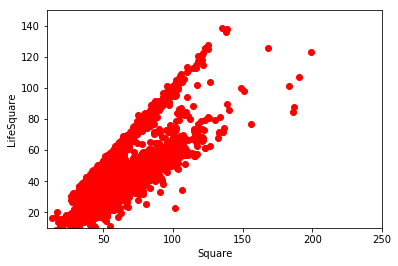

In [258]:
plt.plot(
    data['Square'],
    data['LifeSquare'],
    'ro'
)
plt.xlabel('Square')
plt.ylabel('LifeSquare')
plt.ylim(10,150)
plt.xlim(10,250)

Видно, что зависимость линейна. Предлагаю признак `LifeSquare` также не включать в итоговый датасет

#### Оценим признак `Square`

In [259]:
data['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

In [260]:
bad_square = data[data.Square < 10]
bad_square.shape[0]

12

Получается, что 12 квартир имеют площадь менее 10.

А давайте их выкинем :)

In [261]:
data.drop(bad_square.index, inplace=True)

#### Оценим признак `HouseYear`

In [262]:
data['HouseYear'].value_counts()

1977        2643
2017         308
2016         304
2015         299
2014         209
1970         194
1969         190
1972         178
1971         177
2018         175
1974         169
1968         162
1965         161
1963         158
1976         155
1973         150
1964         150
1975         150
1967         146
1966         140
1978         129
1962         125
1960         121
1961         113
1982         111
1981         108
1979         107
1980         107
2005         102
1983         101
            ... 
1952          10
1953          10
1931           7
1935           7
1950           7
1939           6
1918           5
1933           5
1937           5
1934           4
1938           4
1951           4
1940           4
1930           3
1942           3
1936           3
1919           3
1917           3
1912           2
1929           2
1932           2
1948           2
1941           2
4968           1
1914           1
1947           1
1916           1
1910          

Видим явно выпадающие значения [4968, 20052011]

Заменим 4968 на 1968, 20052011 на 2008

In [263]:
data.loc[data.HouseYear == 4968, 'HouseYear'] = 1968
data.loc[data.HouseYear == 20052011, 'HouseYear'] = 2008

Ради интереса, построим гистограмму

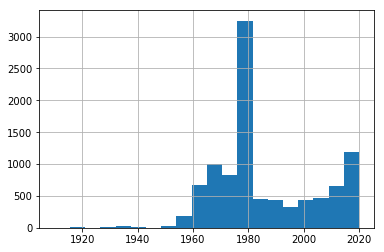

In [264]:
data['HouseYear'].hist(bins=20);

Примечательно - большинство квартир в домах построенных на рубеже конца 1970х - начала 1980х

#### Оценим признак `DistrictId`
Начнем с гистограммы

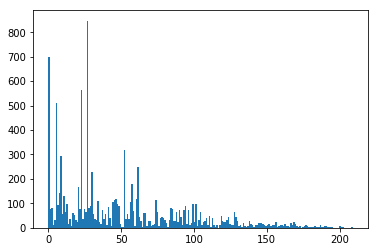

In [265]:
plt.hist(
    data['DistrictId'],
    bins=data['DistrictId'].nunique()
);

Это ничего не дало. Попробуем взять среднюю цену за квадратный метр по району

In [266]:
data['price_per_square'] = data.Price / data.Square

In [267]:
price_per_square_by_District = data.groupby(['DistrictId'])['price_per_square'].mean().reset_index().rename(columns={'price_per_square': 'District_square_price'})

In [268]:
price_per_square_by_District.head(5)

,DistrictId,District_square_price
0,0,3710.401014
1,1,3212.333928
2,2,4560.204511
3,3,3783.790553
4,4,5247.142313


Доавим признак `District_square_price` к датасету

In [269]:
def add_distr_sq_price(df,price_per_square_by_District):
    # Среднее значение цена по всем районам
    dqp_mean = price_per_square_by_District['District_square_price'].mean()
    
    df=pd.merge(df,price_per_square_by_District,on='DistrictId',how='left')
    df['District_square_price']=df['District_square_price'].fillna(dqp_mean)
    return df

In [270]:
# data = add_distr_sq_price(data, price_per_square_by_District).drop(['price_per_square'], axis=1)

In [271]:
data.head(3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,price_per_square
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.930730,3854.958571
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,4567.491245
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,4915.149522


#### Оценим признак `Shops_2`

In [272]:
data['Shops_2'].value_counts()

B    9163
A     825
Name: Shops_2, dtype: int64

Оставим как есть

### Обучение моделей и их применение

#### Разбиение на тренировочные и тестовые

In [273]:
ds = pd.get_dummies(data).drop(
    ['LifeSquare', 'KitchenSquare', 'Healthcare_1','DistrictId'], 
    axis=1
).set_index('Id')

In [274]:
data

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,price_per_square
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,8.903972e-02,...,B,33,7976,5,NaN,0,11,B,184966.930730,3854.958571
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,6.998930e-05,...,B,46,10309,1,240.0,1,16,B,300009.450063,4567.491245
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,4.963726e-02,...,B,34,7759,0,229.0,1,3,B,220925.908524,4915.149522
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,4.378852e-01,...,B,23,5735,3,1084.0,0,5,B,175616.227217,3291.591637
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,1.233889e-02,...,B,35,5776,1,2078.0,2,4,B,150226.531644,3788.892642
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,3.094791e-01,...,B,35,7715,4,990.0,0,6,B,215898.447742,2685.822560
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,4.605564e-01,...,B,20,4386,14,NaN,1,5,B,296021.204377,4755.046491
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,7.577876e-02,...,B,6,1437,3,NaN,0,2,B,221244.156664,2754.776456
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,7.122317e-03,...,B,1,264,0,NaN,0,1,B,229102.795999,3551.351598
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,7.577876e-02,...,B,6,1437,3,NaN,0,2,B,95380.220993,2052.891285


In [275]:
X_train, X_test, y_train, y_test = train_test_split(
    ds.drop(['Price'], axis=1), 
    ds['Price'], 
    test_size=0.2, random_state=42
)

Стандартизируем значения:

In [276]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.keys())
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.keys())

#### Линейная регрессия

In [277]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [278]:
y_pred = lr.predict(X_test_scaled)
y_pred.shape

(1998,)

In [279]:
from sklearn.metrics import r2_score
lr_score = r2_score(y_test, y_pred);
lr_score

0.8142605258857051